In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Visualizing Mutually Non-Exclusive Labels

In [3]:
labels_df = pd.read_csv("selected_labels.csv", index_col=0) # .set_index(keys=labels_df['img_id'], drop=True)

In [4]:
labels_df

,Gate,Start/Restar the game,The joy of the players,yellow card,Red Card,Ball,Stadium View,referee Image,Penalty Image,Free Kick,Generic Moment
Image Number,,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0
94,0,0,0,1,0,1,0,1,0,0,0
95,0,0,0,1,0,1,0,1,0,0,0
96,0,0,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
88281,0,0,0,0,0,1,0,1,0,0,1
35162,0,0,0,0,0,1,0,1,0,0,1
47062,0,0,0,0,0,0,0,0,0,0,1


In [5]:
#labels_df.index.to_list()

In [6]:
labels_df.columns

Index(['Gate', 'Start/Restar the game', 'The joy of the players',
       'yellow card', 'Red Card', 'Ball', 'Stadium View', 'referee Image',
       'Penalty Image', 'Free Kick', 'Generic Moment'],
      dtype='object')

In [7]:
clues_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Gate': labels_df['Gate'].to_list(),
                         'Ball':labels_df['Ball'].to_list(),
                         'Referee':pd.to_numeric(labels_df['referee Image'].astype(str).str.strip(), errors='coerce').fillna(0).astype(int).to_list(),
                         'Red_Card':labels_df['Red Card'].to_list(),
                         'Yellow_Card':labels_df['yellow card'].to_list()}
                         )
clues_df.set_index(clues_df.columns[0], inplace=True)

In [8]:
clues_df.head()

,Gate,Ball,Referee,Red_Card,Yellow_Card
img_id,,,,,
1,0,0,0,0,0
2,0,0,1,0,0
94,0,1,1,0,1
95,0,1,1,0,1
96,0,1,1,0,1


These are binary indicators telling you if the object/clue is present in the image. For now we don’t have the location (bounding boxes) of the objects in the image, but presence is already informative.

check if there are some images in the dataset which do not contain any of the clues:

In [9]:
no_clue_images = clues_df[(clues_df == 0).all(axis=1)]
print(no_clue_images.head())
print(f"There are {len(no_clue_images)} that do not contain any clue")

        Gate  Ball  Referee  Red_Card  Yellow_Card
img_id                                            
1          0     0        0         0            0
1927       0     0        0         0            0
1928       0     0        0         0            0
1929       0     0        0         0            0
1930       0     0        0         0            0
There are 3236 that do not contain any clue


We still have 6764 images containing at least one clue

In [10]:
for x in clues_df.T.columns:
    if clues_df.T[x].sum() == 5:
        print(x)

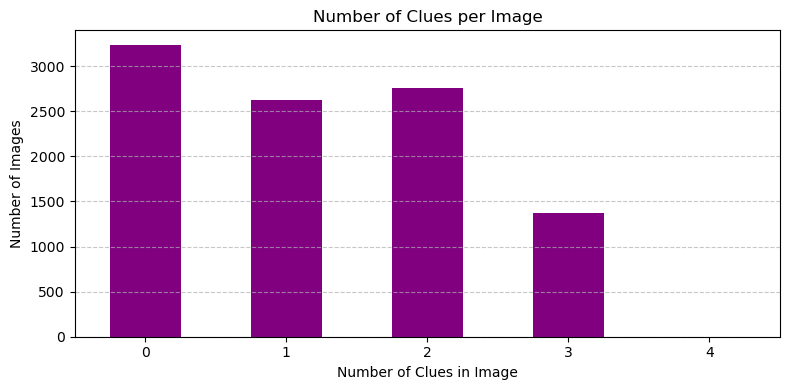

In [11]:
clue_counts = clues_df.sum(axis=1)

# Count how many images have 0, 1, 2, ..., n clues
clue_count_distr = clue_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 4))
clue_count_distr.plot(kind='bar', color='purple')
plt.title("Number of Clues per Image")
plt.xlabel("Number of Clues in Image")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

However, we can still consider images without any clue (i.e., all zeros) as valid. They might represent neutral moments (e.g., mid-field play) or scenes without distinctive objects.

If the architecture concatenates a clue vector (e.g., [Gate, Ball, Referee, ...]) to image features, an all-zero vector is just one possible input — no problem. We keep in mind that the model might learn that a vector of all 0s corresponds to certain classes (e.g., “generic moment”), which may or may not be desirable.

- Mask Augmentation:
    In the case we feed binary masks (e.g., ball mask, gate mask) as additional input channels, an image with no clues will have empty mask channels.
    This is fine, in order to let the model learn that “absence of signal” is also a signal.


- Training Bias:
    Of course, if very few images have clues, the model may ignore them. In the same way, if most of them have clues, the model may depend on them too heavily and fail to generalize.

In [12]:
for x in clues_df.columns:
    print(f'Clue {x} appears {clues_df[x].sum()} times')

Clue Gate appears 4150 times
Clue Ball appears 4220 times
Clue Referee appears 3254 times
Clue Red_Card appears 70 times
Clue Yellow_Card appears 586 times


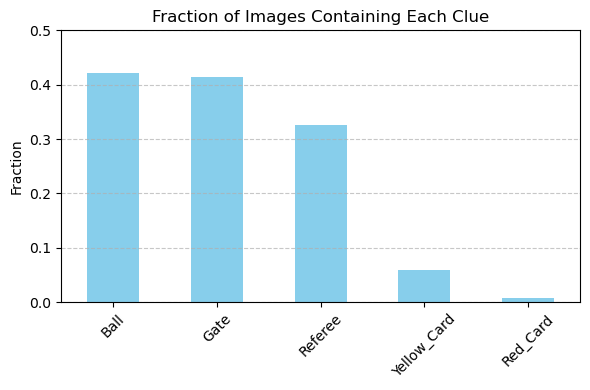

In [13]:
clue_fractions = (clues_df > 0).sum() / clues_df.shape[0]

# Plot
plt.figure(figsize=(6, 4))
clue_fractions.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Fraction of Images Containing Each Clue")
plt.ylabel("Fraction")
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Weight on rare clues:
    - rare clues like red card can be highly discriminative (e.g., if a red card is present, the scene probably relates to a sending-off event).
    - Due to scarcity, they should not dominate the model loss
    - they shouldn’t be dropped, either

- Keep them in the clue vector — let the classifier learn their informativeness
- Also, even though red_card and yellow_card are hardly co-occurring, it is better not to merge them in a new label 'Card_Presence' to allow the model to learn their difference (?????)

(In MLP classifier, use dropout + batch norm to prevent overfitting to rare clues)?

You could apply manual weighting only if you observe the model ignoring rare clues during ablation

 already have weak labels for object presence at the image level, which makes your task a weakly supervised feature enrichment problem rather than pure object detection.

## Problem

in the 10,000 image dataset, many images contain some clues, but the corresponding indicator in the *clues_df* is set to 0.

- A. Do object detection on the images that have the wrong label
- B. 

### Feature Vectors

A. Can convert each row into a feature vector of clues, which will later be fed into the classification model as additional **feature input**.

The images go into the CNN --> the clue vector goes into the MLP. So will concatenate CNN embedding + clue vector and feed it into the final classifier (MLP + softmax for the mutually exclusive match events).

Feed one at a time, then all of them together???

In [19]:
ball_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Ball': labels_df['Ball'].to_list()}
                         )
ball_df.set_index(ball_df.columns[0], inplace=True)
ball_df.head(5)
len(ball_df)

10000

In [8]:
## gate_df
gate_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Gate': labels_df['Gate'].to_list()}
                         )
gate_df.set_index(gate_df.columns[0], inplace=True)

# red_card
r_card_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Red_Card': labels_df['Red_Card'].to_list()}
                         )
r_card_df.set_index(r_card_df.columns[0], inplace=True)

# yellow_card
y_card_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Yellow_Card': labels_df['Yellow_Card'].to_list()}
                         )
y_card_df.set_index(y_card_df.columns[0], inplace=True)

referee_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Referee': labels_df['Referee'].to_list()}
                         )
referee_df.set_index(referee_df.columns[0], inplace=True)

Designing a localization-aware signal for important objects like the ball (with **no ground-truth coordinates**)